<a href="https://colab.research.google.com/github/oksuzian/Mu2eANL/blob/master/Macros/BackgroundEstimatorMu2eII.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Inits

In [ ]:
#!pip -q uninstall -y imgaug && pip uninstall albumentations && pip install git+https://github.com/aleju/imgaug.git

import matplotlib.pyplot as plt
#!pip -q install mplhep==0.3.23
#import mplhep as hep
#hep.style.use('ATLAS')  # or ATLAS/LHCb2

In [ ]:
import sys
import pandas as pd
h5file='drive/MyDrive/root_files_cry4/cry4df.h5'

# This allows you to run on Colaboratory and load files from your Google Drive
try:
    from google.colab import drive
    drive.mount("/content/drive")
    main_path = '/content/drive/MyDrive/'
except:
    main_path = ''
sys.path.append(main_path)
sys.path.append(main_path+'root_files_cry4')
from utils import Utils
util = Utils()
import math

#plt.style.use('seaborn-whitegrid')
#plt.rcParams["grid.linestyle"] = (5,15)
#plt.rcParams["grid.linewidth"] = 0.7
plt.rcParams["figure.figsize"] = (14,7)
plt.rcParams.update({'font.size': 20})

Mounted at /content/drive


In [ ]:
TMIN = -125
TMAX = 50
PMIN_EXT = 90
PMAX_EXT = 140
PMIN_PHY = 104.05
PMAX_PHY = 104.90


#Default MDC-style cut box
cuts = [
    "(de_status > 0)",
    "(deent_td > 0.577350)",
    "(deent_td < 1.000)",
    "(deent_d0 > -80)",
    "(deent_d0 < 105)",
    "((deent_d0 + 2./deent_om) > 450)",
    "((deent_d0 + 2./deent_om) < 680)",
    "(is_triggered)"
]
cut_tbox = " & ".join(cuts)

#PID, TrkQual and cut on events with an usptream leg
cuts = [
    "(dequal_TrkQual > 0.8)",
    "(dequal_TrkPID > 0.95)",
    "(ue_status <= 0)"
]
cut_pid_trkqual_ue = " & ".join(cuts)

# Extended momentum window cut`
cuts = [
    "(deent_mom > %f)" % PMIN_EXT,
    "(deent_mom < %f)" % PMAX_EXT
]
cut_extmom = " & ".join(cuts)

# Physics momentum window cut`
cuts = [
    "(deent_mom > %f)" % PMIN_PHY,
    "(deent_mom < %f)" % PMAX_PHY,
]
cut_phymom = " & ".join(cuts)

# Loose box cuts
cuts = [
    "(deent_td > 0.577350)",
    "(deent_td < 1.000)",
    "(deent_d0 > -80)",
    "(deent_d0 < 205)",
    "((deent_d0 + 2./deent_om) > 450)",
    "(is_triggered)"
]
cut_lbox = " & ".join(cuts)


crv_time = "( crvinfo__dT < %d | crvinfo__dT > %d)" % (TMIN, TMAX)
#Combime cuts
cut_nomom  = cut_tbox +" & "+cut_pid_trkqual_ue
cut_extmom = cut_tbox +" & "+cut_pid_trkqual_ue+" & "+cut_extmom
cut_phymom = cut_tbox +" & "+cut_pid_trkqual_ue+" & "+cut_phymom
cut_loose  = cut_lbox +" & "+cut_pid_trkqual_ue

cut_current = cut_extmom+" & "+crv_time

#Load dataframe

In [ ]:
df = pd.read_hdf(h5file, mode='r')

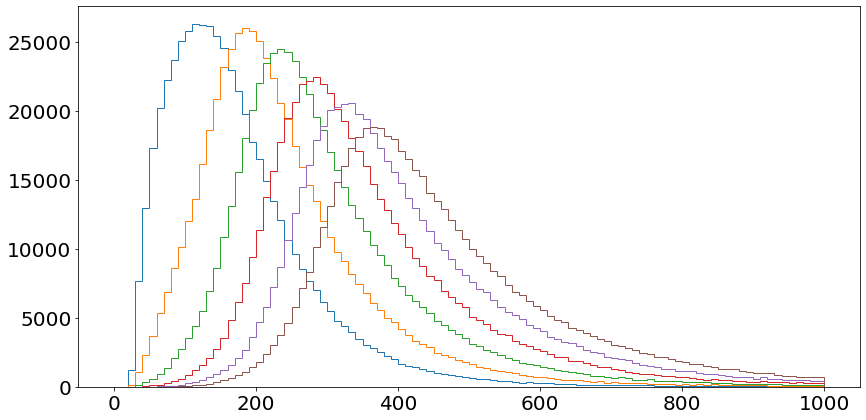

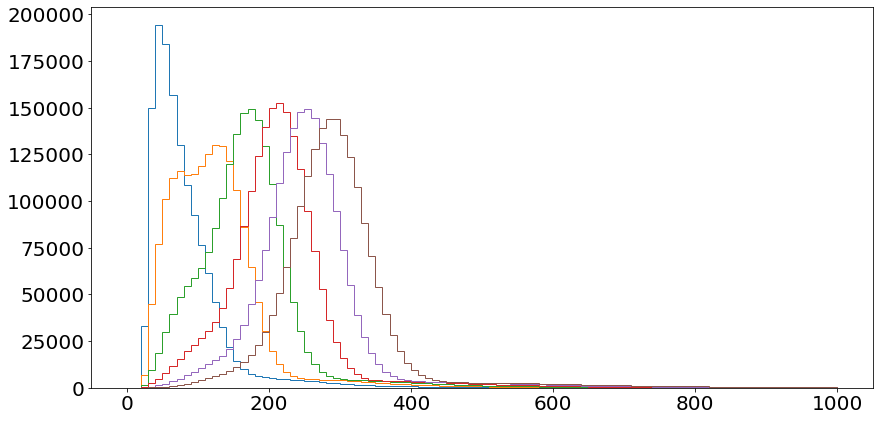

In [ ]:
for l in range(7000,17001,2000):
  plt.hist(df.query('is_high==1 & lyield==%i' % l)['crvinfo__PEs'], bins=100, range=(0, 1000), histtype='step');
plt.figure()
for l in range(7000,17001,2000):
  plt.hist(df.query('is_high==0 & lyield==%i' % l)['crvinfo__PEs'], bins=100, range=(0, 1000), histtype='step');

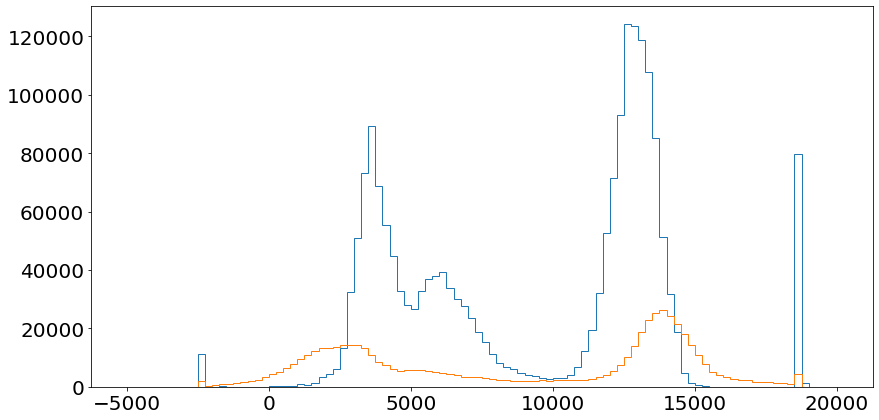

In [ ]:
plt.hist(df.query('is_high==0 & lyield==%i' % 17000)['_z'], bins=100, range=(-5000, 20000), histtype='step');
plt.hist(df.query('is_high==1 & lyield==%i' % 17000)['_z'], bins=100, range=(-5000, 20000), histtype='step');

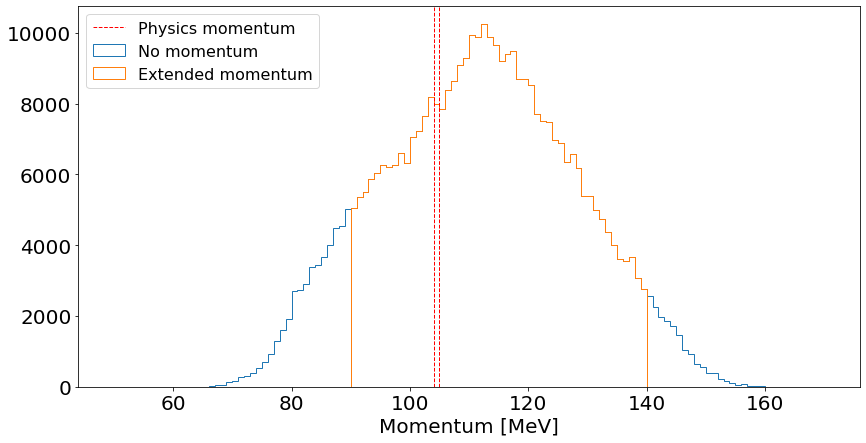

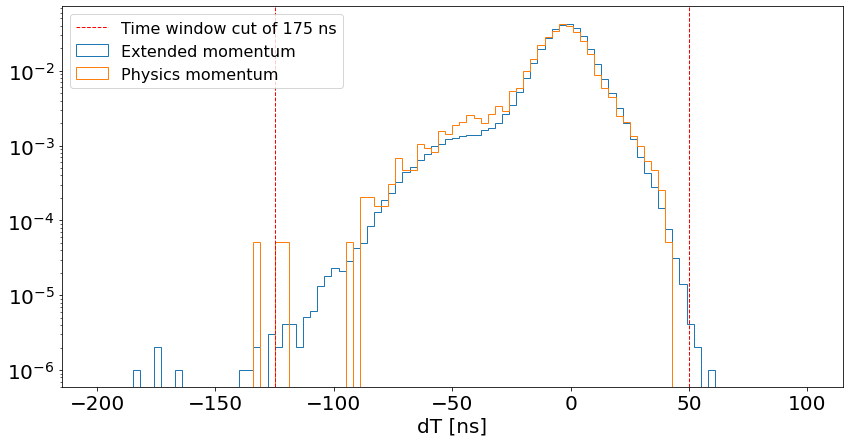

In [ ]:
neve_extmom = len(df.query(cut_extmom))
neve_physmom = len(df.query(cut_phymom))
mom_scale = neve_extmom/neve_physmom
label = r'$\frac{P_{ext}}{P_{phy}} = %.1f$' % mom_scale
_, bins, _ = plt.hist(df.query(cut_nomom)['deent_mom'], bins=120, range=[50, 170], histtype='step', label='No momentum');
plt.hist(df.query(cut_extmom)['deent_mom'], bins=bins, histtype='step', label='Extended momentum');
plt.axvline(PMIN_PHY, color='r', linestyle='--', linewidth=1)
plt.axvline(PMAX_PHY, color='r', linestyle='--', label='Physics momentum', linewidth=1)
plt.legend(loc='upper left', prop={'size': 16})
plt.xlabel('Momentum [MeV]')

plt.figure()
plt.hist(df.query(cut_extmom)['crvinfo__dT'], bins=100, range=(-200, 100), histtype='step', density=True, label='Extended momentum');
plt.hist(df.query(cut_phymom)['crvinfo__dT'], bins=100, range=(-200, 100), histtype='step', density=True, label='Physics momentum');
plt.axvline(TMIN, color='r', linestyle='--', linewidth=1)
plt.axvline(TMAX, color='r', linestyle='--', linewidth=1, label='Time window cut of 175 ns')
plt.yscale('log')
plt.xlabel('dT [ns]');
plt.legend(loc='upper left', prop={'size': 16})

In [ ]:
util = Utils()
util.pritnLiveTimes()

LIVETIME_MU2E: 3.460000e+06
LIVETIME_HI: 5.490000e+06
LIVETIME_LO: 1.869000e+08


In [ ]:

util.LIVETIME_MU2E = 4.27E7

#Background estimation: production sources

In [ ]:
def plot_background(cut_query, title, altitude_scale, log_scale=True, make_plot=True):

  lyield_scale=0.001726
  bg_ave = []
  pe_ave = []
  bg_err = []
  print(title)

  for ly in range(7000,17001,2000):
    bg = util.getNormBackground(df, cut_query+" & lyield =="+str(ly), mom_scale)
    bg_ave.append(bg[0]*altitude_scale)
    pe_ave.append(ly*lyield_scale)
    bg_err.append(bg[1]*math.sqrt(altitude_scale))
    print("PE: %.1f, bg: %3.4f, err: %3.4f" % (ly*lyield_scale, bg[0]*altitude_scale, bg[1]))

  plt.errorbar(pe_ave, bg_ave, yerr=bg_err, fmt='.k');
  plt.title(title)
  if log_scale:
    plt.yscale('log')
  return (bg_ave, pe_ave, bg_err)

Muons inside CRV
PE: 12.1, bg: 138.3799, err: 3.3580
PE: 15.5, bg: 26.5187, err: 1.3471
PE: 19.0, bg: 4.4291, err: 0.4477
PE: 22.4, bg: 0.8961, err: 0.1628
PE: 25.9, bg: 0.5804, err: 0.2187
PE: 29.3, bg: 0.2265, err: 0.1538
Non-muons
PE: 12.1, bg: 0.7415, err: 0.0416
PE: 15.5, bg: 0.6380, err: 0.0386
PE: 19.0, bg: 0.6294, err: 0.0384
PE: 22.4, bg: 0.6294, err: 0.0384
PE: 25.9, bg: 0.6294, err: 0.0384
PE: 29.3, bg: 0.6466, err: 0.0389
Muons outside CRV
PE: 12.1, bg: 0.1933, err: 0.0288
PE: 15.5, bg: 0.0943, err: 0.0201
PE: 19.0, bg: 0.0849, err: 0.0191
PE: 22.4, bg: 0.0849, err: 0.0191
PE: 25.9, bg: 0.0896, err: 0.0196
PE: 29.3, bg: 0.0802, err: 0.0185


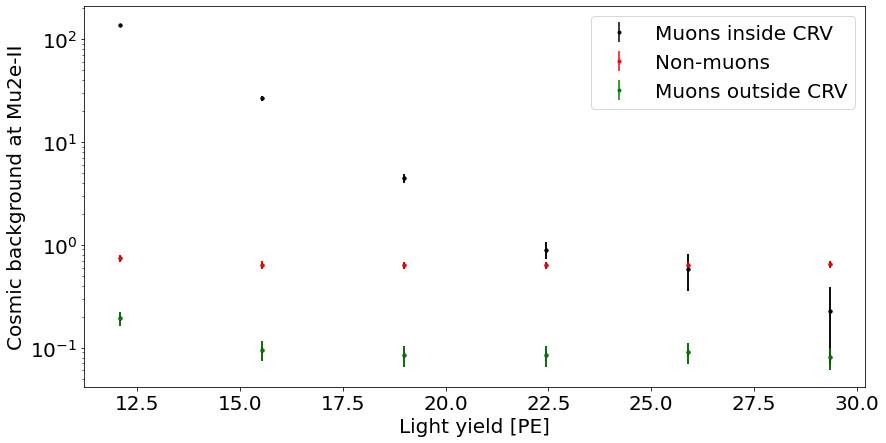

In [ ]:
title='Muons inside CRV'
bg_ave, pe_ave, bg_err = plot_background(cut_current+" & _crvSectorType > 0 & abs(demcgen_pdg) == 13", title, 1.05, False, False)
plt.errorbar(pe_ave, bg_ave, yerr=bg_err, fmt='.k', label=title)

title = 'Non-muons'
bg_ave, pe_ave, bg_err = plot_background(cut_current+" & abs(demcgen_pdg) != 13", title, 1.2*1.6, False, False) #1.2: correction on altitude, 1.6: data driven correction 
plt.errorbar(pe_ave, bg_ave, yerr=bg_err, fmt='.r', label=title)

title = 'Muons outside CRV'
bg_ave, pe_ave, bg_err = plot_background(cut_current+" & _crvSectorType < 0 & abs(demcgen_pdg) == 13", title, 1.05, False, False)
plt.errorbar(pe_ave, bg_ave, yerr=bg_err, fmt='.g', label=title)
plt.legend()
plt.yscale('log');
#plt.title('Cosmic backrgound from various sources');
plt.title('')
plt.xlabel('Light yield [PE]')
plt.ylabel('Cosmic background at Mu2e-II');

#Background estimation: CRV regions

Background from muons inside the fiducial CRV region
PE: 12.1, bg: 138.3799, err: 3.3580
PE: 15.5, bg: 26.5187, err: 1.3471
PE: 19.0, bg: 4.4291, err: 0.4477
PE: 22.4, bg: 0.8961, err: 0.1628
PE: 25.9, bg: 0.5804, err: 0.2187
PE: 29.3, bg: 0.2265, err: 0.1538
Background from muons outside of fiducial CRV region
PE: 12.1, bg: 0.1933, err: 0.0288
PE: 15.5, bg: 0.0943, err: 0.0201
PE: 19.0, bg: 0.0849, err: 0.0191
PE: 22.4, bg: 0.0849, err: 0.0191
PE: 25.9, bg: 0.0896, err: 0.0196
PE: 29.3, bg: 0.0802, err: 0.0185
Background from non-muons
PE: 12.1, bg: 0.4634, err: 0.0416
PE: 15.5, bg: 0.3988, err: 0.0386
PE: 19.0, bg: 0.3934, err: 0.0384
PE: 22.4, bg: 0.3934, err: 0.0384
PE: 25.9, bg: 0.3934, err: 0.0384
PE: 29.3, bg: 0.4041, err: 0.0389


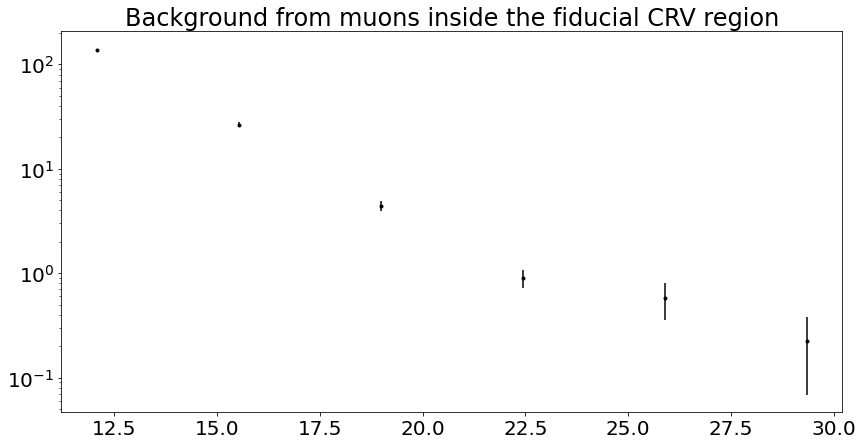

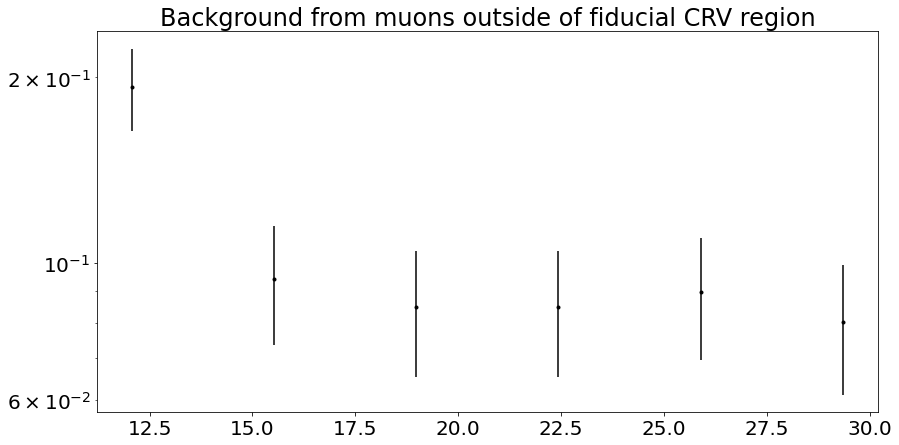

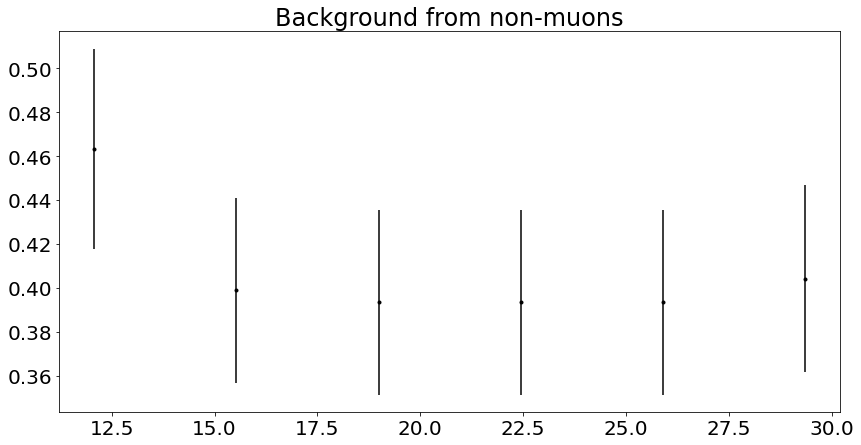

In [ ]:
title='Background from muons inside the fiducial CRV region'
plot_background(cut_current+" & _crvSectorType > 0 & abs(demcgen_pdg) == 13", title, 1.05)

plt.figure()
title = 'Background from muons outside of fiducial CRV region'
plot_background(cut_current+" & _crvSectorType < 0 & abs(demcgen_pdg) == 13", title, 1.05)

plt.figure()
title = 'Background from non-muons'
plot_background(cut_current+" & abs(demcgen_pdg) != 13", title, 1.2, False);

Background from sector R
PE: 12.1, bg: 0.7032, err: 0.2666
PE: 15.5, bg: 0.0943, err: 0.0201
PE: 19.0, bg: 0.0377, err: 0.0127
PE: 22.4, bg: 0.0094, err: 0.0064
PE: 25.9, bg: 0.0141, err: 0.0078
PE: 29.3, bg: 0.0094, err: 0.0064
Background from sector L
PE: 12.1, bg: 0.0566, err: 0.0156
PE: 15.5, bg: 0.0094, err: 0.0064
PE: 19.0, bg: 0.0000, err: 0.0000
PE: 22.4, bg: 0.0000, err: 0.0000
PE: 25.9, bg: 0.0000, err: 0.0000
PE: 29.3, bg: 0.0000, err: 0.0000
Background from sector T
PE: 12.1, bg: 137.0867, err: 3.3368
PE: 15.5, bg: 26.3867, err: 1.3469
PE: 19.0, bg: 4.3866, err: 0.4475
PE: 22.4, bg: 0.8678, err: 0.1625
PE: 25.9, bg: 0.5615, err: 0.2186
PE: 29.3, bg: 0.2124, err: 0.1536
Background from sector E
PE: 12.1, bg: 0.0047, err: 0.0045
PE: 15.5, bg: 0.0047, err: 0.0045
PE: 19.0, bg: 0.0047, err: 0.0045
PE: 22.4, bg: 0.0047, err: 0.0045
PE: 25.9, bg: 0.0047, err: 0.0045
PE: 29.3, bg: 0.0047, err: 0.0045
Background from sector U
PE: 12.1, bg: 0.1605, err: 0.1529
PE: 15.5, bg: 0.0000, 

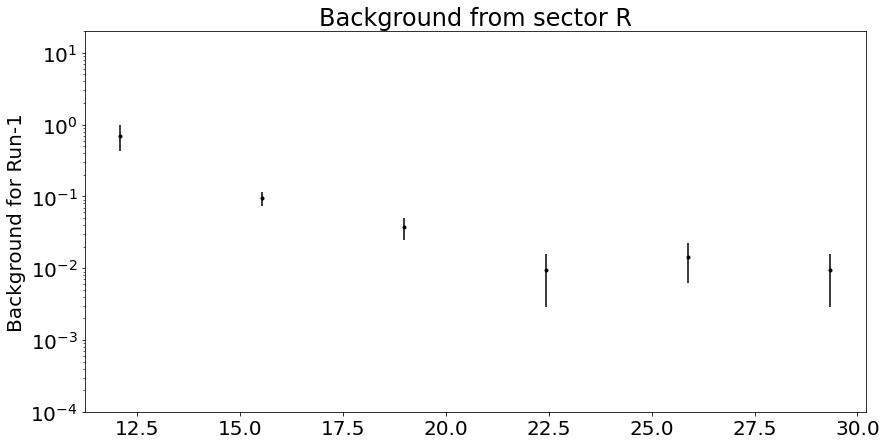

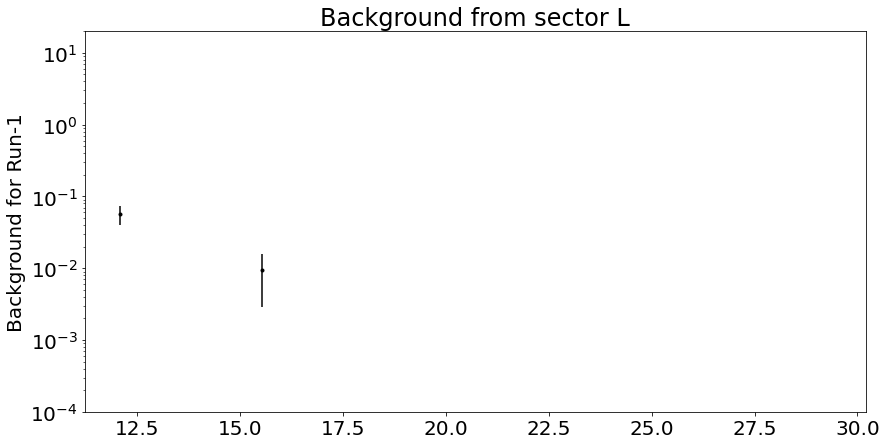

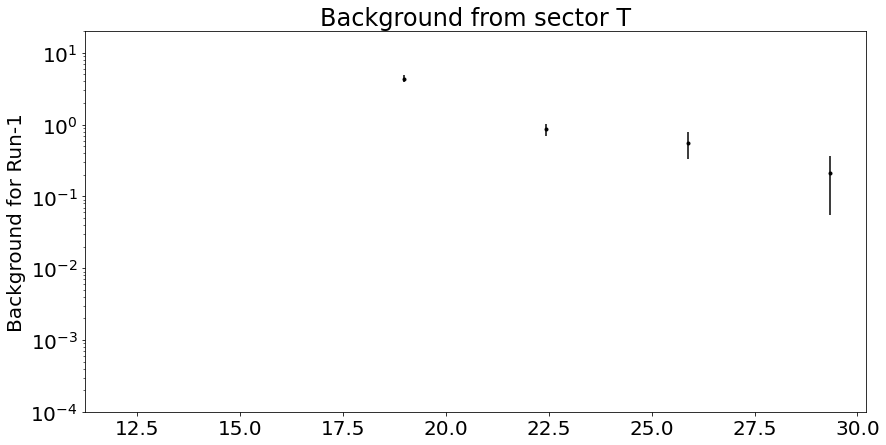

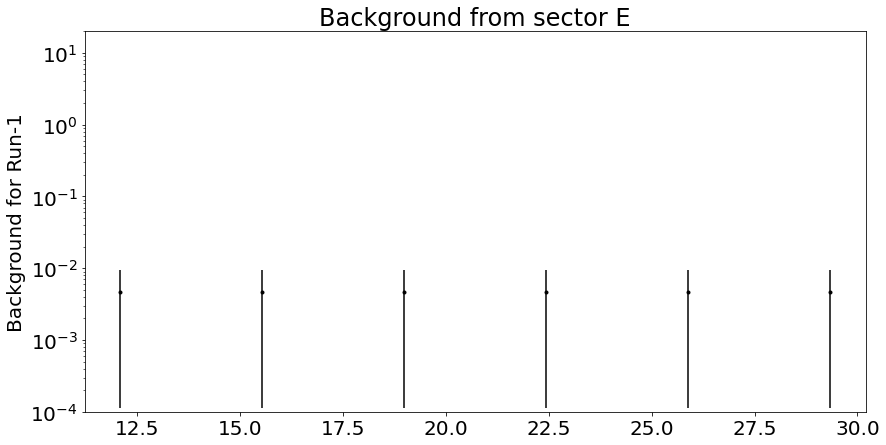

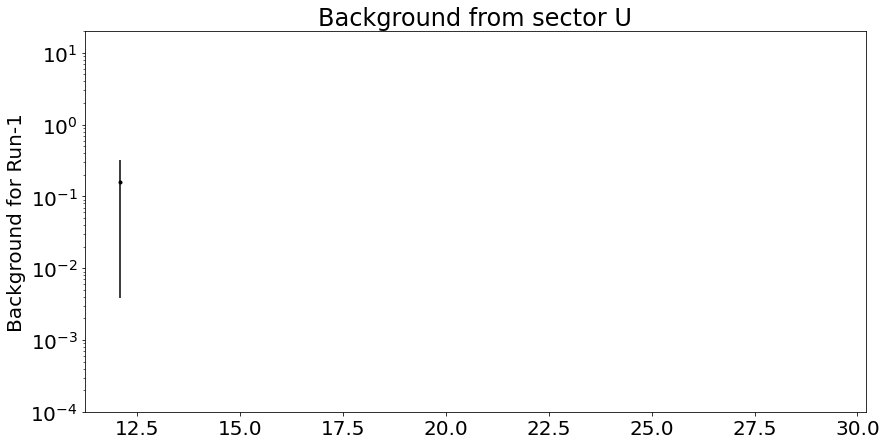

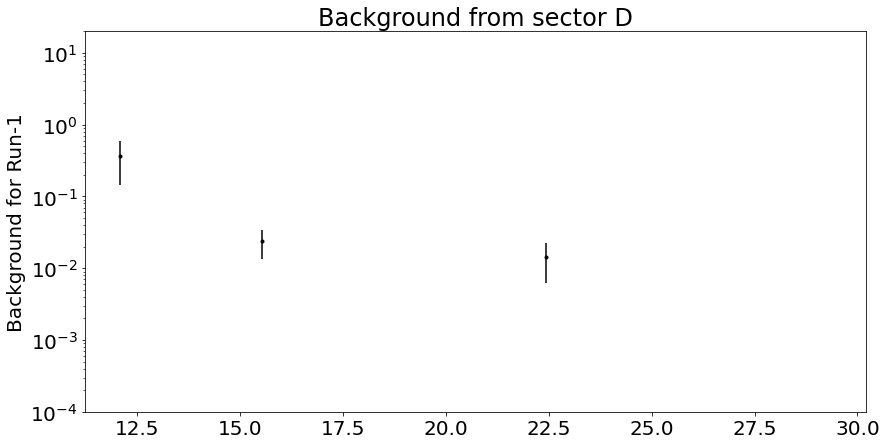

In [ ]:
crvSectorLabel = ['R', 'L', 'T', 'E', 'U', 'D']
for crvSectorType in range(1,7):
  plt.figure()
  title='Background from sector %s' % crvSectorLabel[crvSectorType-1]
  cut_ = cut_current+(" & _crvSectorType ==%d  & abs(demcgen_pdg) == 13" % crvSectorType)
  plot_background(cut_, title, 1.05)
  plt.ylim(0.0001, 20)
  plt.ylabel('Background for Run-1')